### Mnist 학습 예제로 Tensorflow 연습
(작성) by funmv

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist 데이터셋은 tf 내부에 테스트 샘플로 미리 준비되어 있어 가져와 사용하면 됨

In [2]:
mnist     = input_data.read_data_sets('data', one_hot=True)    #label은 one-hot벡터로 취함
X_train   = mnist.train.images
Y_train   = mnist.train.labels
X_test    = mnist.test.images
Y_test    = mnist.test.labels


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### 입력된 mnist 데이터의 tensor 크기를 출력해 본다. 
데이터는 학습용과 검증용 2가지 종류이다.   
학습용은 28x28=784 pixels 크기의 흑백 영상이 55,000개이다.   
검증용은 10,000개이며, label은 10개부류를 가진다.   

In [3]:
dimX = X_train.shape[1]
dimY = Y_train.shape[1]
nTrain = X_train.shape[0]
nTest = X_test.shape[0]
print ("Shape of (X_train, X_test, Y_train, Y_test)")
print (X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


Shape of (X_train, X_test, Y_train, Y_test)
((55000, 784), (10000, 784), (55000, 10), (10000, 10))


어떤 하나의 샘플에 대해 인덱스로 접근해서 영상 및 크기 출력 해봄  

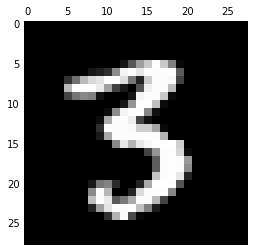

In [4]:
myIdx = 36436   # any number
img   = np.reshape(X_train[myIdx, :], (28, 28)) # 28 * 28 = 784

plt.matshow(img, cmap=plt.get_cmap('gray'))
plt.show()

In [5]:
print X_train.shape, Y_train.shape, dimX, dimY

(55000, 784) (55000, 10) 784 10


### 학습을 위한 최소한의 구조를 만들어 본다.
(1) 먼저 학습 샘플을 저장할 placeholder를 만든다  
(2) 학습 변수를 저장할 W, b를 선언한다  
(3) get_shape()으로 크기를 출력해 본다  

In [6]:
X = tf.placeholder(tf.float32,[None,784],name='input')
Y = tf.placeholder(tf.float32,[None,10],name='label')
W = tf.Variable(tf.zeros([784,10]), name='weight')
b = tf.Variable(tf.zeros([10]), name='bias')
print X.get_shape(), Y.get_shape(), W.get_shape(), b.get_shape()

(?, 784) (?, 10) (784, 10) (10,)


변수들을 곱해주는 graph의 노드를 생성한다

In [7]:
ss = tf.matmul(X,W)
y_pred = tf.nn.softmax(tf.add( tf.matmul(X,W) , b))
print y_pred.get_shape()

(?, 10)


### 학습 샘플은 작은 규모의 batch로 나누어져 입력하기 때문에 loss계산에 평균을 적용한다
먼저 xentropy loss함수를 구성한다  
각 샘플의 label과 log(predict) 두 값을 곱한 결과를 sum한 후, 모든 샘플에 대해 평균한다.  
reduction_indices=1 is along label axis. Usually in matrix, 0(row), 1(col)

In [8]:
loss = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(y_pred), reduction_indices=1))

loss에 대한 gradient를 정의한다. 최적화 인자값을 설정한다. 

In [9]:
learning_rate = 0.005
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
training_epoch = 20
batch_size = 100
display_epoch = 2

tf.argmax와 tf.equal함수를 같이 사용하면 출력값 평가를 간단하게 할 수 있다.  
label Y(one-hot)의 최대값과 prediction y_pred의 최대값의 위치가 같은지 체크한다.  

In [10]:
correct_pred = tf.equal(tf.argmax(Y,1),tf.argmax(y_pred,1))

테스트된 모든 샘플들에 대해 correct_pred 값을 평균하여 accuracy값을 계산한다. 

In [11]:
accuracy = tf.reduce_mean(tf.cast(correct_pred,'float32'))

### 연산을 위해 Session을 시작한다. 먼저 모든 변수를 초기화하고, 20번의 epoch를 실행한다
batch 샘플의 수를 100개로 했고 이에 따라 전체 batch 덩어리의 수가 결정된다(nBatch)  
사용할 batch 샘플의 index는 매 epoch마다 랜덤하게 결정된다.  
선택된 batch 샘플들은 feed_dict를 통해 넘겨준다.   

In [12]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    
    for epoch in range(training_epoch):
        nBatch = int(X_train.shape[0]/batch_size)
        batch_index = np.random.permutation(X_train.shape[0]) #55,000/100=550(batch 덩어리 수)
        for ii in range(nBatch):                              #1 epoch는 모든 sample data를 거쳐야 끝남
            x = X_train[batch_index[ii*batch_size:(ii+1)*batch_size],:]
            y = Y_train[batch_index[ii*batch_size:(ii+1)*batch_size],:]
            sess.run(optimizer, feed_dict = {X:x, Y:y})
            
        if (epoch+1)%display_epoch == 0:                      #2 epoch마다 1회씩 결과를 출력
            print '[epoch] ',epoch
            print 'loss =', loss.eval({X:X_train, Y:Y_train}) #loss.eval(입력):입력에 대해 loss계산
            print 'accu_train = ', accuracy.eval({X:X_train, Y: Y_train})
            print 'accu_test = ', accuracy.eval({X:X_test, Y: Y_test})
        
        #print sess.run(loss)

[epoch]  1
loss = 0.770376
accu_train =  0.842873
accu_test =  0.8526
[epoch]  3
loss = 0.592289
accu_train =  0.862582
accu_test =  0.8739
[epoch]  5
loss = 0.520068
accu_train =  0.872309
accu_test =  0.8824
[epoch]  7
loss = 0.47925
accu_train =  0.878618
accu_test =  0.8868
[epoch]  9
loss = 0.452221
accu_train =  0.883273
accu_test =  0.8911
[epoch]  11
loss = 0.432752
accu_train =  0.886618
accu_test =  0.895
[epoch]  13
loss = 0.417795
accu_train =  0.889364
accu_test =  0.8983
[epoch]  15
loss = 0.405923
accu_train =  0.892164
accu_test =  0.9001
[epoch]  17
loss = 0.396094
accu_train =  0.893982
accu_test =  0.9008
[epoch]  19
loss = 0.387888
accu_train =  0.895455
accu_test =  0.9023
